# Notebook Python

In [2]:
import pandas as pd
import numpy as np
import prince

import matplotlib.pyplot as plt
import seaborn as sns

# Data loading

In [3]:
gym = pd.read_csv('gym_members_exercise_tracking.csv')

display(gym.head().style.background_gradient(cmap='Reds'))
gym.info()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.300000,1.710000,180,157,60,1.690000,1313.000000,Yoga,12.600000,3.500000,4,3,30.200000
1,46,Female,74.900000,1.530000,179,151,66,1.300000,883.000000,HIIT,33.900000,2.100000,4,2,32.000000
2,32,Female,68.100000,1.660000,167,122,54,1.110000,677.000000,Cardio,33.400000,2.300000,4,2,24.710000
3,25,Male,53.200000,1.700000,190,164,56,0.590000,532.000000,Strength,28.800000,2.100000,3,1,18.410000
4,38,Male,46.100000,1.790000,188,158,68,0.640000,556.000000,Strength,29.200000,2.800000,3,1,14.390000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

In [7]:
gym_cat = gym.select_dtypes(include='object')
gym_num = gym.select_dtypes(exclude='object')

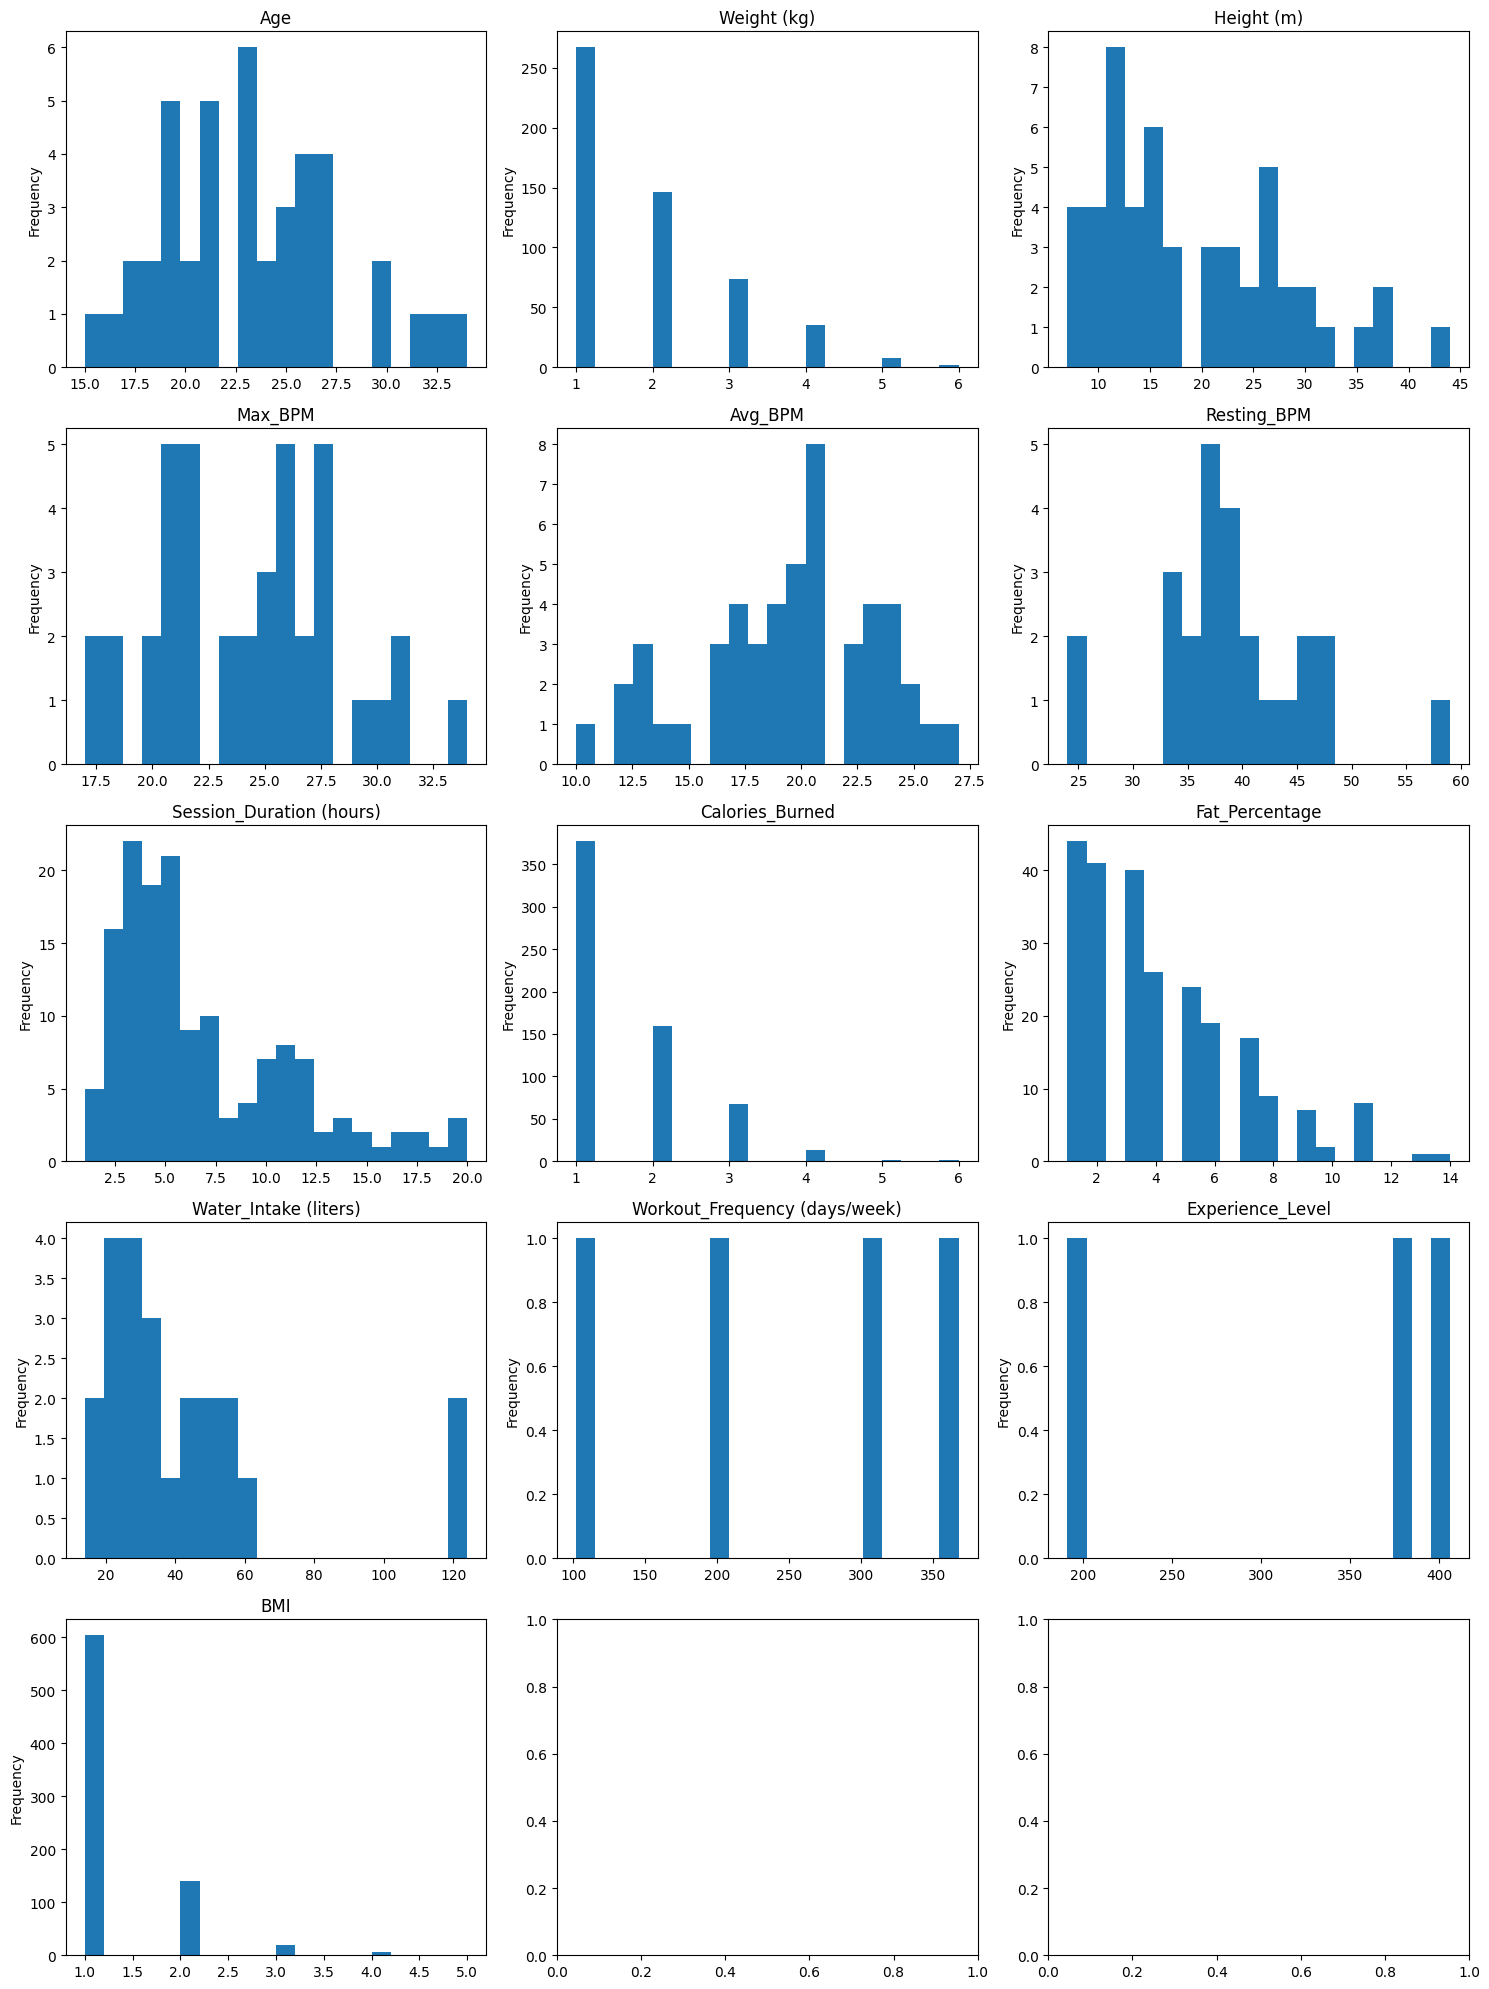

In [30]:
# Create a 5x3 grid of subplots
fig, axes = plt.subplots(5, 3, figsize=(15, 20))
axes = axes.flatten()

columns = [
    'Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
    'Session_Duration (hours)', 'Calories_Burned', 'Fat_Percentage', 'Water_Intake (liters)',
    'Workout_Frequency (days/week)', 'Experience_Level', 'BMI'
]


# Plot each column in a separate subplot
for i, col in enumerate(columns):
    gym_num[col].value_counts().plot(kind='hist', ax=axes[i], bins=20)
    axes[i].set_title(col)

# plt.hist(gym_num['Age'].value_counts())

# Adjust layout
plt.tight_layout()
plt.show()

# Modelisation
## Prédiction des calories brûlées

In [19]:
from sklearn.preprocessing import StandardScaler
# train split
from sklearn.model_selection import train_test_split

X = gym.drop(columns=['Calories_Burned', 'Gender', 'Workout_Type', 'Experience_Level', 'Workout_Frequency (days/week)'], axis=1)
y = gym['Calories_Burned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# adding the intercept
X_train = np.c_[np.ones(X_train.shape[0]), X_train] # concatenate over the second axis in order to X = [[1,vector_1],[1,vector_2],...]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]

Cette étape est nécessaire car...

In [20]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False)  # Already added intercept manually
model.fit(X_train, y_train)

y_pred_train_sklearn = model.predict(X_train)
y_pred_test_sklearn = model.predict(X_test)


In [21]:
from sklearn.metrics import mean_squared_error, r2_score

rmse_train_sklearn = mean_squared_error(y_train, y_pred_train_sklearn)
rmse_test_sklearn = mean_squared_error(y_test, y_pred_test_sklearn)
r2_train_sklearn = r2_score(y_train, y_pred_train_sklearn)
r2_test_sklearn = r2_score(y_test, y_pred_test_sklearn)

In [22]:
print("Scikit-Learn Model - Training RMSE:", rmse_train_sklearn, "R2:", r2_train_sklearn)
print("Scikit-Learn Model - Testing RMSE:", rmse_test_sklearn, "R2:", r2_test_sklearn)

Scikit-Learn Model - Training RMSE: 2123.199095827944 R2: 0.972162953425033
Scikit-Learn Model - Testing RMSE: 1953.539884853544 R2: 0.9700536287469038


[]

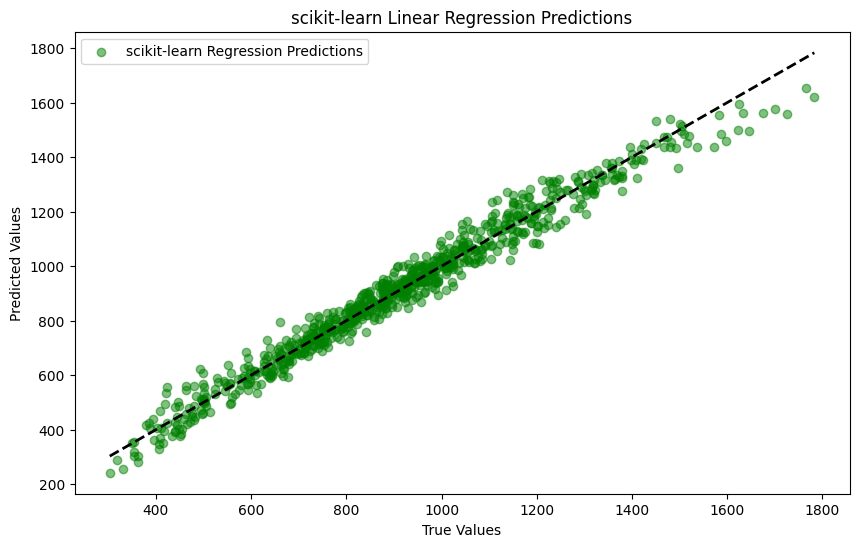

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train_sklearn, color='green', alpha=0.5, label='scikit-learn Regression Predictions')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('scikit-learn Linear Regression Predictions')
plt.legend()

plt.plot()

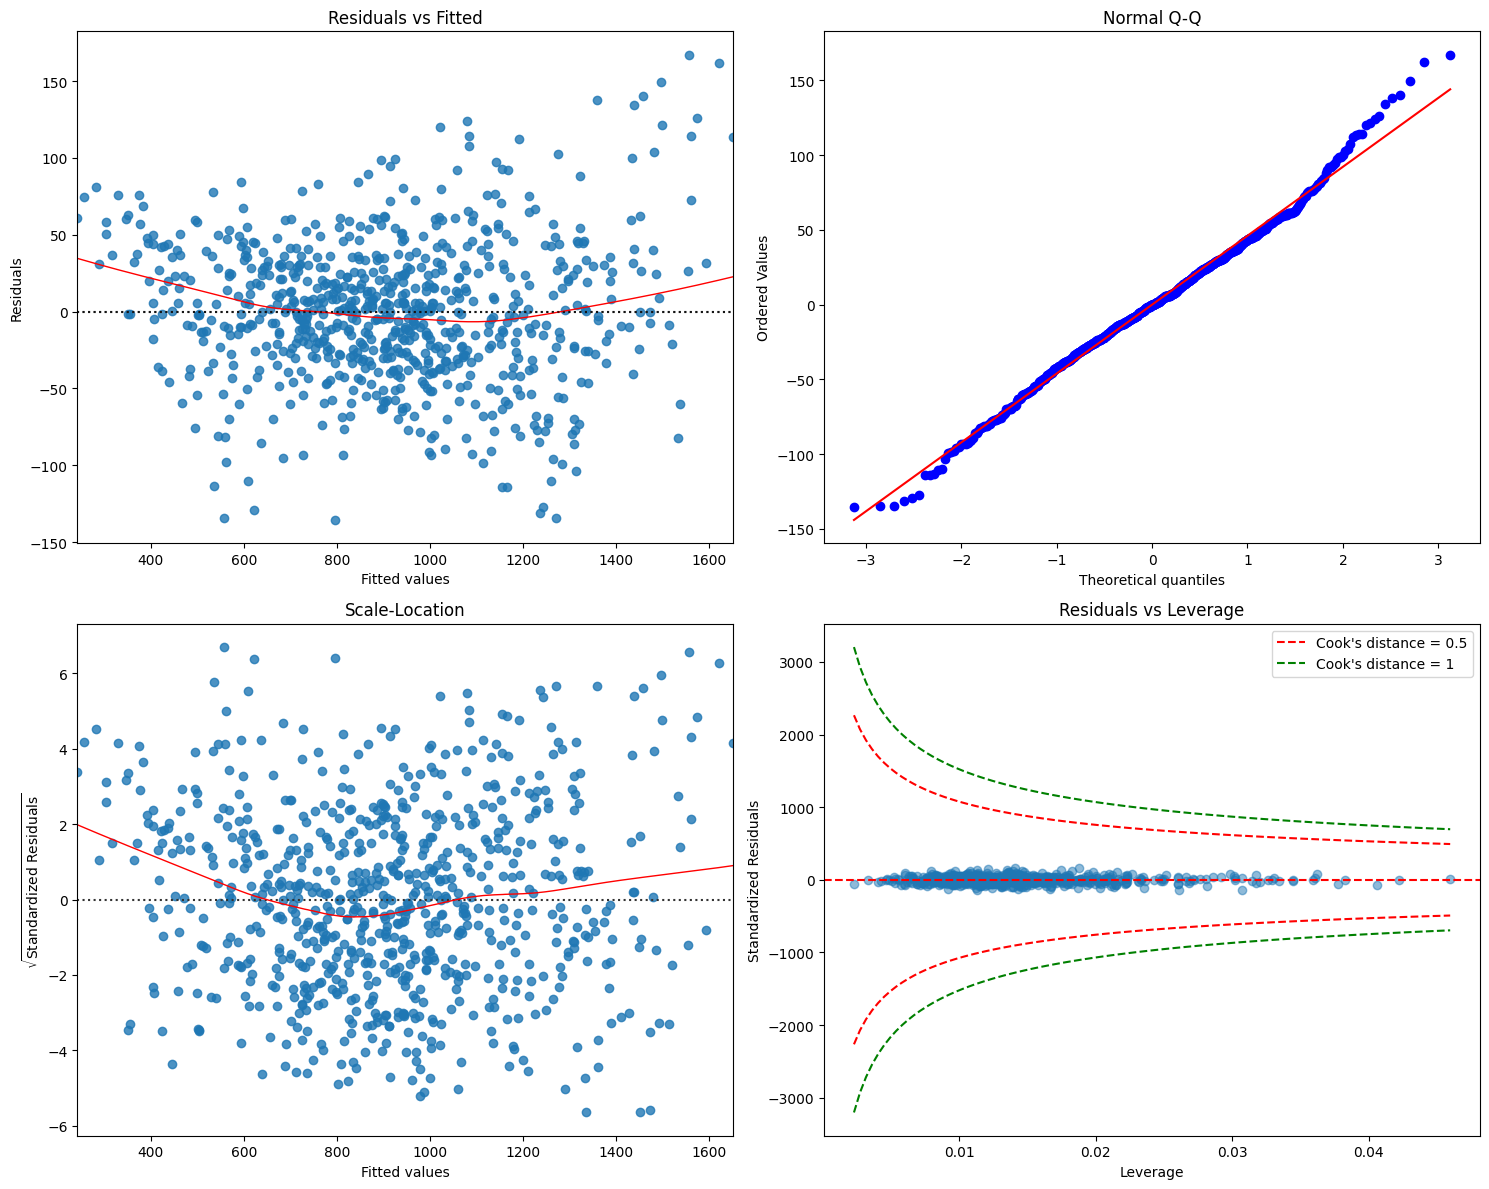

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

# Calcul des résidus
residuals_train = y_train - y_pred_train_sklearn

# Création de la figure et des subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# 1. Résidus vs Valeurs ajustées
sns.residplot(x=y_pred_train_sklearn, y=residuals_train, lowess=True, line_kws={'color':'red', 'lw':1}, ax=axs[0,0])
axs[0, 0].axhline(0, color='black', linestyle='dotted', alpha=0.6)
axs[0, 0].set_xlabel("Fitted values")
axs[0, 0].set_ylabel("Residuals")
axs[0, 0].set_title("Residuals vs Fitted")

# 2. Graphique Q-Q
stats.probplot(residuals_train, dist="norm", plot=axs[0, 1])
axs[0, 1].set_title("Normal Q-Q")

# 3. Scale-Location
sns.residplot(x=y_pred_train_sklearn, y=np.sqrt(np.abs(residuals_train)), lowess=True, line_kws={'color':'red', 'lw':1}, ax=axs[1,0])
axs[1, 0].set_xlabel("Fitted values")
axs[1, 0].set_ylabel(r"$\sqrt{\text{Standardized Residuals}}$")
axs[1, 0].set_title("Scale-Location")

# 4. Leverage vs Résidus
# Calcul du leverage pour les sous-graphiques
hat_matrix = X_train @ np.linalg.inv(X_train.T @ X_train) @ X_train.T
leverage = np.diag(hat_matrix)

# Calcul de Cook's distance
n, p = X_train.shape  # nombre d'observations et nombre de paramètres
MSE = np.mean(residuals_train**2)
cooks_d = (residuals_train**2 / (p * MSE)) * (leverage / (1 - leverage)**2)

axs[1, 1].scatter(leverage, residuals_train, alpha=0.5)
axs[1, 1].axhline(0, color='red', linestyle='--')
axs[1, 1].set_xlabel("Leverage")
axs[1, 1].set_ylabel("Standardized Residuals")
axs[1, 1].set_title("Residuals vs Leverage")


# Ajout des courbes de Cook à 0.5 et 1
x_vals = np.linspace(min(leverage), max(leverage), 100)
cooks_0_5 = np.sqrt(0.5 * p * MSE * (1 - x_vals) / x_vals)
cooks_1 = np.sqrt(1 * p * MSE * (1 - x_vals) / x_vals)

axs[1, 1].plot(x_vals, cooks_0_5, 'r--', label="Cook's distance = 0.5")
axs[1, 1].plot(x_vals, -cooks_0_5, 'r--')
axs[1, 1].plot(x_vals, cooks_1, 'g--', label="Cook's distance = 1")
axs[1, 1].plot(x_vals, -cooks_1, 'g--')

# Légende pour les courbes de Cook
axs[1, 1].legend()

# Ajustement de l'espace entre les sous-plots
plt.tight_layout()
plt.show()


### Interpretation
1. **Residials vs Fitted values**: 
This plot shows residuals against fitted values to assess model linearity. In this case, the red line isn't horizontal but in a banana form, indicating that the residuals have a quadratic pattern.
2. **Q-Q plot**: Most points align with the diagonal, suggesting that residuals are normally distribued. Minor deviations at the tails indicate potential outliers or slight non-normality, but overall, the residuals are sufficiently normal for this model.
3. **Scale-Location Plot**: This plot assesses homoscedasticity, ideally showing a horizontal spread of points, emphasised by the red line. ~~Again, the red line is roughly horizontal, suggesting the possibility of homoscedasticity. While mostly consistent, slight variation in spread suggests mild heteroscedasticity, implying that variance stabilization techniques could improve the model.~~
4. **Residuals vs Leverage with Cook’s Distance**:
This plot identifies influential observations, with Cook’s distance curves at 0.5 and 1. No points fall outside these thresholds, indicating no single observation overly influences the model. This suggests that the model is robust to individual data points.

#### Conclusion 
Overall, the diagnostics show that the model follows the linear regression assumptions fairly well, with a few areas for improvement:
- Slightly uncertain homoscedasticity (Scale-Location).
- No major influential values (thanks to Cook's distance curves).

Possible improvements could include transforming the variables to ensure homoscedasticity and exploring non-linear terms to better capture the variance of the residuals.